In [31]:
import sys, os, time, pprint
import numpy as np
import pandas as pd

sys.path.append("..")
import milvus_utilities as _utils

In [11]:
df = pd.read_csv("data/process.csv")

df['text'] = df['Name'] + ' ' + df['Description'] + ' ' + df['ReviewBody']

print(df.shape[0])
df = df.dropna(subset=['text'])
print(df.shape[0])

df['Genres'] = df['Genres'].str.split(',')
df['Genres'] = df['Genres'].apply(lambda d: d if isinstance(d, list) else [""])

df['Actors'] = df['Actors'].str.split(',')
df['Actors'] = df['Actors'].apply(lambda d: d if isinstance(d, list) else [""])

df['Keywords'] = df['Keywords'].str.split(',')
df['Keywords'] = df['Keywords'].apply(lambda d: d if isinstance(d, list) else [""])

def extract_year(movie_date):
    try:
        return int(movie_date.split('-')[0])
    except Exception:
        return -1
df['MovieYear'] = df.DatePublished.apply(extract_year)

df['RatingValue'] = pd.to_numeric(df['RatingValue'], errors='coerce')
df['RatingValue'] = df['RatingValue'].fillna(-1).astype('float32')

df.drop(columns=['RatingCount', 'BestRating', 'WorstRating',
                 'ReviewAurthor', 'ReviewDate', 'ReviewBody',
                 'Description', 'duration', 'DatePublished'], inplace=True)

print(f"Example text length: {len(df.text[0])}")
pprint.pprint(f"Example text: {df.text[0]}")

df = df.tail(250).copy()

print(df.dtypes)
display(df.head(2))

100
62
Example text length: 6556
('Example text: Sallie Gardner at a Gallop Sallie Gardner at a Gallop is a '
 'short starring Gilbert Domm and Sallie Gardner. The clip shows a jockey, '
 'Domm, riding a horse, Sally Gardner. The clip is not filmed but instead '
 'consists of 24 individual photographs shot in rapid... Sometimes ascribed as '
 '"The Father of the Motion Picture", Eadweard Muybridge undeniably '
 'accomplished exploiting and sometimes introducing a means of instantaneous '
 'and serial images to analyze and synthesize animal locomotion. In part, the '
 "reasons for and the claims made of his work support Virgilio Tosi's thesis "
 'that cinema was invented out of the needs of scientific research. '
 "Conversely, they're informed by Muybridge's background as an artistic "
 'location photographer and, as Phillip Prodger suggests, in book sales and '
 'more useful to art than to science, as Marta Braun has demonstrated (see '
 'sources at bottom). Additionally, Muybridge qui

,id,url,Name,PosterLink,Genres,Actors,Director,Keywords,RatingValue,text,MovieYear
0,0,https://www.imdb.com/title/tt2221420/,Sallie Gardner at a Gallop,https://m.media-amazon.com/images/M/MV5BMjk0Mz...,"[Documentary, Short]","[Gilbert Domm, Sallie Gardner]",Eadweard Muybridge,"[19th century, 1870s, nature, horse, horse rid...",7.4,Sallie Gardner at a Gallop Sallie Gardner at a...,1878
3,3,https://www.imdb.com/title/tt0343112/,Traffic Crossing Leeds Bridge,https://m.media-amazon.com/images/M/MV5BYjZhZj...,"[Documentary, Short]",[Cj Pallister],Louis Aimé Augustin Le Prince,"[bridge, street life, 1880s, traffic, horse]",6.7,Traffic Crossing Leeds Bridge Traffic Crossing...,-1


In [12]:
import pymilvus
from pymilvus import MilvusClient

print(f"pymilvus: {pymilvus.__version__}")
mc = MilvusClient(uri="http://localhost:19530")

pymilvus: 2.6.2


In [13]:
import torch 
from sentence_transformers import SentenceTransformer

torch.backends.cudnn.deterministic = True
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

model_name = "BAAI/bge-large-en-v1.5"
encoder = SentenceTransformer(model_name, device=DEVICE)

EMBEDDING_DIM = encoder.get_sentence_embedding_dimension()
MAX_SEQ_LENGTH_IN_TOKENS = encoder.get_max_seq_length()

MAX_SEQ_LENGTH = MAX_SEQ_LENGTH_IN_TOKENS * 3
EOS_TOKEN_LENGTH = 1 * 3

MAX_SEQ_LENGTH = MAX_SEQ_LENGTH_IN_TOKENS
EOS_TOKEN_LENGTH = 1

print(f"model_name: {model_name}")
print(f"embedding_dim: {EMBEDDING_DIM}")
print(f"max_seq_length: {MAX_SEQ_LENGTH}")

model_name: BAAI/bge-large-en-v1.5
embedding_dim: 1024
max_seq_length: 512


In [9]:
# Finishing up

COLLECTION_NAME = "Imdb_metadata"

if mc.has_collection(COLLECTION_NAME):
    mc.drop_collection(COLLECTION_NAME)
    print(f"Successfully dropped collection: `{COLLECTION_NAME}`")


mc.create_collection(COLLECTION_NAME,
                     EMBEDDING_DIM,
                     consistency_level="Eventually",
                     auto_id=True,
                     metric_type="IP",
                     overwrite=True,
                     )
print(f"Successfully created collection: `{COLLECTION_NAME}`")

Successfully dropped collection: `Imdb_metadata`
Successfully created collection: `Imdb_metadata`


In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def recursive_splitter_wrapper(text, chunk_size):
    chunk_overlap = np.round(chunk_size * 0.10, 0)
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
    )
    chunks = text_splitter.split_text(text)

    chunks = [text.replace("<br /><br />", " ") for text in chunks]

    return chunks

def imdb_chunk_text(batch_size, df, chunk_size):
    batch = df.head(batch_size).copy()
    print(f"chunk size: {chunk_size}")
    print(f"original shape: {batch.shape}")

    print(f"Also batch size may differ from {batch_size} to {len(df)}")
    
    start_time = time.time()

    batch['chunk'] = batch['text'].apply(recursive_splitter_wrapper, chunk_size=chunk_size)
    batch = batch.explode('chunk', ignore_index=True)
    print(f"new shape: {batch.shape}")

    embeddings = torch.tensor(encoder.encode(batch['chunk']))
    embeddings = np.array(embeddings / np.linalg.norm(embeddings))

    converted_values = list(map(np.float32, embeddings))
    batch['vector'] = converted_values

    end_time = time.time()
    print(f"Chunking + embedding time for {batch_size} docs: {end_time - start_time} sec")

    assert len(batch.chunk[0]) <= MAX_SEQ_LENGTH-1
    assert len(batch.vector[0] == EMBEDDING_DIM)
    print(f"type embeddings: {type(batch.vector)} of {type(batch.vector[0])}")
    print(f"of numbers: {type(batch.vector[0][0])}")

    return batch

In [16]:
chunk_size =512
chunk_overlap = np.round(chunk_size * 0.10, 0)

BATCH_SIZE = 800
batch = imdb_chunk_text(BATCH_SIZE, df, chunk_size)
display(batch.head(2))

batch.drop(columns=['id', 'text'], axis=1, inplace=True)

chunk size: 512
original shape: (62, 11)
Also batch size may differ from 800 to 62
new shape: (254, 12)
Chunking + embedding time for 800 docs: 72.01066589355469 sec
type embeddings: <class 'pandas.core.series.Series'> of <class 'numpy.ndarray'>
of numbers: <class 'numpy.float32'>


/var/folders/r4/dp3q02rx14lcf4mg7lgqtnp80000gn/T/ipykernel_98274/986418545.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  embeddings = np.array(embeddings / np.linalg.norm(embeddings))


,id,url,Name,PosterLink,Genres,Actors,Director,Keywords,RatingValue,text,MovieYear,chunk,vector
0,0,https://www.imdb.com/title/tt2221420/,Sallie Gardner at a Gallop,https://m.media-amazon.com/images/M/MV5BMjk0Mz...,"[Documentary, Short]","[Gilbert Domm, Sallie Gardner]",Eadweard Muybridge,"[19th century, 1870s, nature, horse, horse rid...",7.4,Sallie Gardner at a Gallop Sallie Gardner at a...,1878,Sallie Gardner at a Gallop Sallie Gardner at a...,"[0.0017392188, 0.00088550965, 0.0044410275, -0..."
1,0,https://www.imdb.com/title/tt2221420/,Sallie Gardner at a Gallop,https://m.media-amazon.com/images/M/MV5BMjk0Mz...,"[Documentary, Short]","[Gilbert Domm, Sallie Gardner]",Eadweard Muybridge,"[19th century, 1870s, nature, horse, horse rid...",7.4,Sallie Gardner at a Gallop Sallie Gardner at a...,1878,"animal locomotion. In part, the reasons for an...","[0.0013205261, -7.3755305e-05, 0.0027188999, -..."


In [20]:
print(batch.isnull().sum())

batch_clean = batch.fillna('')

url            0
Name           0
PosterLink     0
Genres         0
Actors         0
Director       6
Keywords       0
RatingValue    0
MovieYear      0
chunk          0
vector         0
dtype: int64


In [21]:
dict_list = batch_clean.to_dict(orient='records')

print("Start inserting entities")
start_time = time.time()
insert_result = mc.insert(
    COLLECTION_NAME,
    data=dict_list,
    progress_bar=True
)
end_time = time.time()
print(f"Milvus Client insert time for {batch.shape[0]} vectors: {end_time - start_time} seconds")

Start inserting entities
Milvus Client insert time for 254 vectors: 0.13849186897277832 seconds


In [22]:
print(len(dict_list))
print(type(dict_list[0]), len(dict_list[0]))
pprint.pprint(dict_list[0])

254
<class 'dict'> 11
{'Actors': ['Gilbert Domm', 'Sallie Gardner'],
 'Director': 'Eadweard Muybridge',
 'Genres': ['Documentary', 'Short'],
 'Keywords': ['19th century', '1870s', 'nature', 'horse', 'horse riding'],
 'MovieYear': 1878,
 'Name': 'Sallie Gardner at a Gallop',
 'PosterLink': 'https://m.media-amazon.com/images/M/MV5BMjk0MzM1NDUtMTIyNi00Y2Y3LWEwNzEtMDQ1NmU4YzgzYWU2XkEyXkFqcGdeQXVyMjM3NTU0NTQ@._V1_.jpg',
 'RatingValue': 7.400000095367432,
 'chunk': 'Sallie Gardner at a Gallop Sallie Gardner at a Gallop is a short '
          'starring Gilbert Domm and Sallie Gardner. The clip shows a jockey, '
          'Domm, riding a horse, Sally Gardner. The clip is not filmed but '
          'instead consists of 24 individual photographs shot in rapid... '
          'Sometimes ascribed as "The Father of the Motion Picture", Eadweard '
          'Muybridge undeniably accomplished exploiting and sometimes '
          'introducing a means of instantaneous and serial images to analyze '
    

In [23]:
OUTPUT_FIELDS = list(dict_list[0].keys())
OUTPUT_FIELDS.remove('vector')
print(OUTPUT_FIELDS)

['url', 'Name', 'PosterLink', 'Genres', 'Actors', 'Director', 'Keywords', 'RatingValue', 'MovieYear', 'chunk']


In [24]:
GENRES = list(set([genre for genres in df['Genres'] for genre in genres]))
print(GENRES)

['Drama', 'History', 'Family', 'Comedy', 'Action', 'Sport', 'Sci-Fi', 'Crime', 'Fantasy', 'Biography', 'Music', 'Documentary', 'Romance', 'Horror', 'Short']


<Axes: >

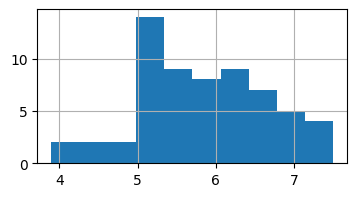

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,2))
df['RatingValue'].hist()

In [35]:
SAMPLE_QUESTION = "Dystopia science fiction with a robot."

In [27]:
def mc_run_search(question, filter_expression, top_k):
    query_embeddings = _utils.embed_query(encoder, [question])

    results = mc.search(
        COLLECTION_NAME,
        data=query_embeddings,
        output_fields=OUTPUT_FIELDS,
        filter=filter_expression,
        limit=top_k,
        consistency_level="Eventually"
    )

    METADATA_FIELDS = [f for f in OUTPUT_FIELDS if f != 'chunk']
    formatted_results, context, context_metadata = _utils.client_assemble_retrieved_context(
        results, metadata_fields=METADATA_FIELDS, num_shot_answers=TOP_K
    )

    return formatted_results, context, context_metadata

In [37]:
TOP_K = 3
expression = ""
expression='rating >= 6.5'

expression=expression + ' && (genres[0] like "Sci-Fi%" || genres[1] like "Sci-Fi%" || genres[2] == "Sci-Fi")'

print(f"filter: {expression}")

start_time = time.time()
formatted_results, contexts, context_metadata = \
    mc_run_search(SAMPLE_QUESTION, expression, TOP_K)
elapsed_time = time.time() - start_time
print(f"Milvus Client search time for {len(dict_list)} vectors: {elapsed_time} seconds")

print(f"type: {type(formatted_results)}, count: {len(formatted_results)}")

filter: rating >= 6.5 && (genres[0] like "Sci-Fi%" || genres[1] like "Sci-Fi%" || genres[2] == "Sci-Fi")


2025-09-20 14:51:34,705 [ERROR][handler]: RPC error: [search], <MilvusException: (code=Unsupported field type: 0, message=)>, <Time:{'RPC start': '2025-09-20 14:51:34.541412', 'RPC error': '2025-09-20 14:51:34.705157'}> (decorators.py:140)
2025-09-20 14:51:34,708 [ERROR][search]: Failed to search collection: Imdb_metadata (milvus_client.py:425)


MilvusException: <MilvusException: (code=Unsupported field type: 0, message=)>

In [ ]:
from Ipython.display import Image
from Ipython.display import display

seen_movies = []

for i in range(len(contexts)):
    print(f"Retrieved result #{i+1}")
    print(f"distance = {formatted_results[i][0]}")

    movie_index = context_metadata[i]['movie_index']
    print(f"movie_index: {movie_index}")

    if movie_index in seen_movies:
        continue
    else:
        seen_movies.append(movie_index)
        x = Image(url = context_metadata[i]['poster_url'], width=150, height=200)
        display(x)

        pprint.pprint(f"chunk: {contexts[i]}")

        for key, value in context_metadata[i].items():
            if ((key != 'poster_url') and (key != 'movie_index')):
                print(f"{key}: {value}")
        print()



